In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from src import loader, embedding, rdit

COLABDIR = '/scratch/fl1092/followup-editors/collab/'
PROJDIR = '/scratch/fl1092/COIpaper/'
MAGDIR = '/scratch/fl1092/MAG/2021-12-06/'

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib

cm = 1/2.54  # centimeters in inches
plt.rcParams.update({'font.size': 7})


matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5

plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams["font.family"] = "sans-serif"

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [3]:
def cosineSim(a, b):
    # cosine similarity function
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

def getPaperEditorSimilarity(df, autEmbedding, papEmbedding):
    # df stores editor-paper pairs
    
    return (
        df.rename(columns={'EditorId':'AuthorId'})

        .merge(autEmbedding, on='AuthorId')

        .rename(columns={'Embed':'EditorVector'})
        .drop(['AuthorId'],axis=1)

        .merge(papEmbedding, on='PaperId')

        .assign(Similarity = lambda df: df.apply(lambda row: cosineSim(row['Embed'],row['EditorVector']), axis=1))
    )

In [4]:
%%time
paperAuthorSubset = pd.read_csv(COLABDIR + 'PaperAuthorSubset.csv',sep='\t')
randomEditorBaseline = pd.read_csv(PROJDIR + 'expertise/RandomEditorBaseline.csv')
randomEditorJournalBaseline = pd.read_csv(PROJDIR + 'expertise/RandomEditorSameJournalBaseline.csv')

paperEditor = loader.loadPaperEditor()
info = loader.loadPaperInfo()
recvDate, acptDate = loader.loadPaperRecvAcptTime()

grapePaperAut, grapePaperPap = embedding.grapePaper(paperAuthorSubset)

CPU times: user 1min 57s, sys: 7.68 s, total: 2min 5s
Wall time: 2min 7s


# Expertise similarity distribution compared with randomized baseline

In [5]:
grapePaperResults = {
    'paperEditorSimilarity': getPaperEditorSimilarity(paperEditor, grapePaperAut, grapePaperPap),
    'baselineSimilarity': getPaperEditorSimilarity(randomEditorBaseline, grapePaperAut, grapePaperPap),
    'journalBaselineSimilarity': getPaperEditorSimilarity(randomEditorJournalBaseline, grapePaperAut, grapePaperPap),
}

In [6]:
grapePaperResults['paperEditorSimilarity'][['Similarity']].to_csv('./data/ExpertisePaperEditorSimilarity.csv',index=False)
grapePaperResults['baselineSimilarity'][['Similarity']].to_csv('./data/ExpertiseBaselineSimilarity.csv',index=False)
grapePaperResults['journalBaselineSimilarity'][['Similarity']].to_csv('./data/ExpertiseJournalBaselineSimilarity.csv',index=False)

In [7]:
def plotBoxSwarm(dfs, ax=None, outcome='Similarity'):
    
    if ax is None:
        ax = plt.gca()
        
    swarmToPlot = (
        pd.concat([df.sample(4000).assign(Loc=ind) for ind, df in enumerate(dfs)], ignore_index=True, sort=False)
    )
        
    sns.swarmplot(data=swarmToPlot, y=outcome, x='Loc', ax=ax, size=0.5, color='grey', alpha=0.5)
    ax.boxplot([df[outcome] for df in dfs], positions=[x for x in range(len(dfs))],
               showfliers=False, showmeans=True, 
               boxprops={'linewidth': 1},
               medianprops={'color': '#ff7f00'},
               meanprops={'markersize': 5, 'markeredgecolor':'#1f78b4', 'markerfacecolor':'#1f78b4'}
              )
    
    return ax

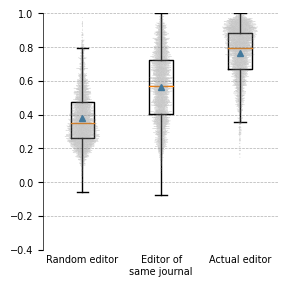

In [8]:
ax = plt.gca()
set_size(6*cm, 6*cm, ax)

ax = plotBoxSwarm([grapePaperResults['baselineSimilarity'],
                   grapePaperResults['journalBaselineSimilarity'],
                   grapePaperResults['paperEditorSimilarity']], ax=ax)

ax.set_ylim(-0.4, 1)
ax.set_yticks([-0.4, -0.2, 0, 0.2, 0.4, .6, .8, 1]) # -1, -0.8, -0.6, 
    
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Random editor', 'Editor of\nsame journal', 'Actual editor'])
ax.set_ylabel("") # Cosine similarity between editor's and papers' expertise
ax.set_xlabel('')

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(length=0, axis='x')
ax.grid(axis='y', ls='--', lw=0.5)

plt.savefig('./figures/expertise_boxplot.pdf', bbox_inches = 'tight', pad_inches = 0)

In [9]:
grapePaperResults['baselineSimilarity'] = None
grapePaperResults['journalBaselineSimilarity'] = None

# Correlation between expertise and editor-author association

In [10]:
def paperCOIExpertise(simDf, paperPotentialEditor):

    return (
        paperPotentialEditor
        .merge(simDf, on=['EditorId','PaperId'])
        .sort_values(by='Similarity',ascending=False)
    )

In [11]:
%%time
collabCOIPaper = pd.read_csv(PROJDIR + 'PotentialPaperEditorCollabCOI.csv')
affCOIPaper = pd.read_csv(PROJDIR + 'PotentialPaperEditorAffCOI.csv')
COIpaper = (
    pd.concat([collabCOIPaper, affCOIPaper], ignore_index=True, sort=False)
    .drop_duplicates()
)

CPU times: user 1.3 s, sys: 77.5 ms, total: 1.38 s
Wall time: 1.47 s


In [12]:
%%time
paperPotentialEditor = (
    pd.read_csv(PROJDIR + 'PaperPotentialEditors.csv')
    
    .merge(paperEditor.drop('publisher',axis=1).assign(Actual=True), on=['PaperId','EditorId'], how='left')
    .merge(COIpaper.assign(COI=True),  on=['PaperId','EditorId'], how='left')

    .fillna({'Actual':False, 'COI':False})
)
# similarity = getPaperEditorSimilarity(paperPotentialEditor, grapePaperAut, grapePaperPap) # takes over 3h
similarity = pd.read_csv(PROJDIR + 'expertise/PapersPotentialEditorEmbedding/grapePaper.csv')
similarityCOI = paperCOIExpertise(similarity, paperPotentialEditor)

CPU times: user 19min 32s, sys: 4min 16s, total: 23min 49s
Wall time: 23min 57s


In [13]:
binned = (
    similarityCOI
    .query('Actual == True')
    
    .assign(ExpBin=lambda df: pd.qcut(df['Similarity'], 20, labels=False))
)

binned.drop(['EditorId','PaperId'], axis=1).to_csv('./data/Expertise_COI_correlation.csv',index=False)

In [14]:
import scipy

def getCI(data, confidence=0.95):
    
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    
    return m, h


def plotCI(df, x, col='COI', x_col='', width=5, ax=None, lo=0, hi=0.14, left=-0.5, right=1.5):
    
    if ax is None: ax = plt.gca()
    
    color = '#e41a1c'
        
    means = df[col].apply(lambda x: x[0])
    errs = df[col].apply(lambda x: x[1])
    
    errs = df[col].apply(lambda x: x[1])
    
    plotline, caplines, barlinecols = ax.errorbar(
        x=x, y=means, yerr=errs, fmt = ' ', marker='_', ms=width+1, ecolor=(0, 0, 0, 0.2),
        elinewidth=width, capsize=0, color=color
    )

    plt.setp(barlinecols[0], capstyle="round", color=color, alpha=0.2)

In [15]:
def plotPointPlot(df, ax=None):
    
    if ax is None:
        ax = plt.gca()
        
    df = df.assign(COI=lambda df: df.COI.astype(int))
    
    toPlot = df.groupby('ExpBin').agg({'COI': getCI}).reset_index()
        
    plotCI(toPlot, x=toPlot.ExpBin, ax=ax)
    
    labelsDf = (
        df.groupby('ExpBin').agg({'Similarity':[min, max]}).reset_index()
        .assign(
            Label=lambda df: df.apply(lambda row: f"[{row['Similarity', 'min']:.2} {row['Similarity', 'max']:.2})",
                                      axis=1)
        )
    )
    
    xticksshow=[_ for _ in range(2, 20, 5)]
    xtickslabel=labelsDf.loc[xticksshow, 'Label'].values

    ax.set_xticks(xticksshow)
    ax.set_xticklabels(xtickslabel)
    
    ax.minorticks_on()
    ax.tick_params('x', length=4, width=1, which='major')
    ax.tick_params(axis='y', which='minor', length=0)
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    
    ax.set_ylim(0, 0.18)
    ax.set_ylim(0, 0.18)
    
    return ax

In [16]:
(
    binned.assign(COI=lambda df: df.COI.astype(int))
    .groupby('ExpBin').agg({'COI': getCI}).reset_index()
)

,ExpBin,COI
0,0,"(0.019511305616338438, 0.0016372157646799548)"
1,1,"(0.026586433260393873, 0.0019042334650109449)"
2,2,"(0.027607585703865792, 0.0019394404643872244)"
3,3,"(0.029468616652686092, 0.0020018615752270237)"
4,4,"(0.0325309992706054, 0.002099948712531187)"
5,5,"(0.03446389496717724, 0.002159274694129273)"
6,6,"(0.03636164703307925, 0.0022157879129169828)"
7,7,"(0.03862144420131291, 0.0022808825729225333)"
8,8,"(0.04139314369073669, 0.0023579029609562168)"
9,9,"(0.04153902261123268, 0.0023618744685401415)"


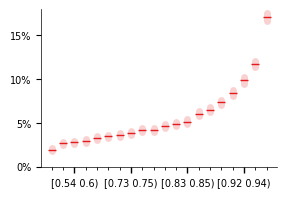

In [17]:
ax = plt.gca()
set_size(6*cm, 4*cm, ax)

ax = plotPointPlot(binned)
ax.set_yticks([0, 0.05, 0.1, 0.15])
ax.set_yticklabels(['0%', '5%', '10%', '15%'])

plt.savefig('./figures/expertise_COI_correlation.pdf', bbox_inches = 'tight', pad_inches = 0)

# Who else can handle this paper? Counterfactual editors who do not have association with any author

In [18]:
%%time
papersActualCOI = similarityCOI.query('Actual==1').query('COI==1').drop(['Actual','COI','EditorId'], axis=1)

COIreplacement = (
    similarityCOI
    .merge(papersActualCOI.drop('Similarity',axis=1), on='PaperId')
    
    .query('COI==0').sort_values(by='Similarity',ascending=False)
    .groupby('PaperId').head(1)
)

COIpairs = (
    COIreplacement.rename(columns={'Similarity':'SimRep'})
    .merge(papersActualCOI, on='PaperId')
    .assign(Diff=lambda df: df.SimRep - df.Similarity)
)

CPU times: user 1min 45s, sys: 10.9 s, total: 1min 56s
Wall time: 1min 56s


In [19]:
COIpairs.drop(['EditorId','PaperId'],axis=1).to_csv('./data/AlternativeEditorExpertiseDifference.csv',index=False)

In [20]:
def plotDelayDist(ax, df=COIpairs):

    sns.histplot(df.Diff, binrange=(-0.6, 1), bins=160, color='#1f78b4', stat='probability', ax=ax, cumulative=True, fill=False, element='step', lw=1)

    ax.set_xlim(-0.6, 1)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('')
    ax.set_ylabel('')

def plotBox(ax, df=COIpairs):
    
    ax.boxplot(
        df.Diff,
        patch_artist=True,positions=[1],
        vert=False,showfliers=False,widths=0.5,
        boxprops=dict(facecolor=hexToDecimal('#1f78b4', 0.5)),
        medianprops=dict(color='black'),
        flierprops = dict(marker='o', markerfacecolor='none', markersize=2, markeredgecolor='black',
                          markeredgewidth=0.1,
                  linestyle='none')
    )
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax.set_xlim(-0.6, 1)
    
def hexToDecimal(h, alpha=1):
    h = h.strip('#')
    return tuple(int(h[i:i+2], 16)/255 if i<6 else alpha for i in (0, 2, 4, 6))

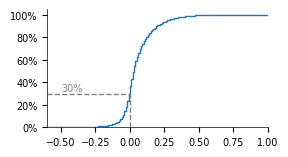

In [21]:
ax = plt.gca()

plotDelayDist(ax)

ax.plot([0.000337, 0.000337], [0, 0.3], ls='--', lw=1, color='grey')
ax.plot([-0.6, 0.000337], [0.3, 0.3], ls='--', lw=1, color='grey')

ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

ax.text(-0.5, 0.32, '30%', color='grey')

set_size(5.6*cm, 3*cm, ax)

plt.savefig('./figures/expertise_non-COI_cummulative.pdf', bbox_inches = 'tight', pad_inches = 0)

# RDiT revisited: Impact of policy change on editor expertise in PNAS

In [22]:
from datetime import datetime

def getPaperByPub(publisher, info=info, recvDate=recvDate):
    
    # filter all the paper for a specific publisher and get the date when those papers are received
    return (
        info.query(f'Publisher == "{publisher}"')
        .merge(recvDate.drop('Year',axis=1), on='PaperId')
    )

def printRegRes(regRes):

    coeff = []
    pval = []
    
    coeff.append(     regRes.params["After[T.True]"] )
    coeff.append( regRes.params["After[T.True]:RecvMonth"] )

    pval.append(     regRes.pvalues.loc['After[T.True]'])
    pval.append( regRes.pvalues.loc['After[T.True]:RecvMonth'])
    
    print(regRes.nobs)

    print(' '.join(["{:.2f}\%".format(i*100) for i in coeff]))
    print(' '.join(["({:.3f})".format(i) for i in pval]))

In [23]:
pastCollaboration = pd.read_csv(COLABDIR + 'PastCollaboration.csv')

In [24]:
mostRecent = (
    pastCollaboration
    .groupby(['PaperId','EditorId']).MonthGap.min().reset_index()
)

In [25]:
pnasPapers = getPaperByPub('pnas')

In [26]:
COIoverTime = (
    pnasPapers
    .merge(paperEditor.rename(columns={'publisher':'Publisher'}), on=['PaperId', 'Publisher'])
    .drop('EditorId', axis=1)
    
    ### time of most recent prior collaboration ###
    .merge(
        mostRecent.drop('EditorId', axis=1)
        
        .assign(Less24=lambda df: df.MonthGap.apply(lambda x: x <= 24))
        .assign(Less48More24=lambda df: df.MonthGap.apply(lambda x: x > 24 and x <= 48)),
        
        on=['PaperId'], how='left'
    )
    .fillna({'Less48More24': False, 'Less24': False})
    .assign(RecvMonth=lambda df: df.RecvDate.apply(rdit.converMonth))
    
    .merge(grapePaperResults['paperEditorSimilarity'], on=['PaperId']) # 30724
)


In [27]:
COIoverTime[['Less24','RecvMonth','Similarity']].to_csv('./data/PNASExpertise_RDiT.csv',index=False)

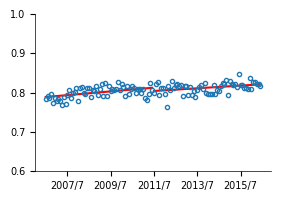

In [28]:
ax = plt.gca()
set_size(6*cm, 4*cm, ax)

_, regRes = rdit.analysis(
    COIoverTime, x='RecvMonth', y='Similarity', cutoff=139,
    RANGE=60, ax=ax, integerY=False
)

ax.set_ylim(0.6, 1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1])

xlabels = ['2007/7', '2009/7', '2011/7', '2013/7', '2015/7']
ax.set_xticks([rdit.converMonth(datetime.strptime(x, '%Y/%m')) for x in xlabels])
ax.set_xticklabels(xlabels)

plt.savefig('./figures/expertise_RDiT.pdf', bbox_inches = 'tight', pad_inches = 0)

In [29]:
regRes.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Similarity   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     20.49
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           1.00e-10
Time:                        04:51:26   Log-Likelihood:                 353.89
No. Observations:                 120   AIC:                            -699.8
Df Residuals:                     116   BIC:                            -688.6
Df Model:                           3                                         
Covariance Type:                  HC3                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.8116      0.003    235.853      0.000       0.805       0.818
After[T.True]              -0.0073      0.005     -1.341      0.180      -0.018       0.003
RecvMonth                   0.0004    9.5e-05      3.950      0.000       0.000       0.001
After[T.True]:RecvMonth -9.886e-05      0.000     -0.683      0.494      -0.000       0.000
==============================================================================
Omnibus:                        2.491   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.288   Jarque-Bera (JB):                2.242
Skew:                          -0.335   Prob(JB):                        0.326
Kurtosis:                       3.012   Cond. No.                         179.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [30]:
for window in [60, 54, 48, 42, 36]:
    print(window)
        
    _, regRes = rdit.analysis(
        COIoverTime, x='RecvMonth', y='Similarity', cutoff=139,
        RANGE=window, ax=ax, integerY=False
    )

    printRegRes(regRes)
    print()

60
120.0
-0.73\% -0.01\%
(0.180) (0.494)

54
108.0
-0.60\% -0.01\%
(0.312) (0.744)

48
96.0
-0.16\% 0.02\%
(0.793) (0.395)

42
84.0
0.32\% 0.00\%
(0.637) (0.919)

36
72.0
0.77\% -0.01\%
(0.282) (0.842)



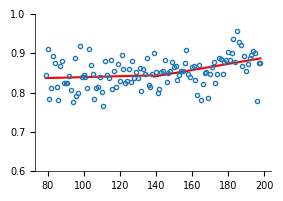

In [31]:
ax = plt.gca()
set_size(6*cm, 4*cm, ax)

_, regRes = rdit.analysis(
    COIoverTime.query('Less24==True'), x='RecvMonth', y='Similarity', cutoff=139,
    RANGE=60, ax=ax, integerY=False
)

ax.set_ylim(0.6, 1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1])

plt.show()

In [32]:
regRes.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Similarity   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     6.084
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           0.000699
Time:                        04:51:26   Log-Likelihood:                 234.55
No. Observations:                 120   AIC:                            -461.1
Df Residuals:                     116   BIC:                            -449.9
Df Model:                           3                                         
Covariance Type:                  HC3                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.8474      0.008    103.999      0.000       0.831       0.863
After[T.True]              -0.0110      0.011     -0.979      0.328      -0.033       0.011
RecvMonth                   0.0002      0.000      0.752      0.452      -0.000       0.001
After[T.True]:RecvMonth     0.0007      0.000      1.756      0.079   -7.86e-05       0.001
==============================================================================
Omnibus:                        1.968   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.374   Jarque-Bera (JB):                1.452
Skew:                          -0.180   Prob(JB):                        0.484
Kurtosis:                       3.401   Cond. No.                         179.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [33]:
for window in [60, 54, 48, 42, 36]:
    print(window)
        
    _, regRes = rdit.analysis(
        COIoverTime.query('Less24==True'), x='RecvMonth', y='Similarity', cutoff=139,
        RANGE=window, ax=ax, integerY=False
    )

    printRegRes(regRes)
    print()

60
120.0
-1.10\% 0.07\%
(0.328) (0.079)

54
108.0
-1.96\% 0.07\%
(0.077) (0.087)

48
96.0
-2.23\% 0.07\%
(0.068) (0.149)

42
84.0
-0.83\% 0.02\%
(0.522) (0.775)

36
72.0
-0.10\% -0.07\%
(0.945) (0.380)

